Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [1]:
NAME = "Marco Mustacchi"
ID_number = int("2054137")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4

## Unsupervised learning

In this notebook we are going to explore the use of unsupervised clustering methods.

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [3]:
# TODO 1: Write a function to compute the probability density function (pdf) of a gaussian random vector:
# you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    normalizing_const = 1.0 / np.sqrt(np.power((2*np.pi), len(sigma)) * np.linalg.det(sigma))
    # raise NotImplementedError() # Remove this line
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters, 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    sigma_inverse = np.linalg.inv(sigma)
    unnomrmalized_pdf = np.exp(-0.5 * (np.matmul((x-mu).T, np.matmul(sigma_inverse, (x-mu)))))
    # raise NotImplementedError() # Remove this line
    return gv_normalizing_const(sigma) * unnomrmalized_pdf

In [4]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters.

Can you tell how many clusters have been used by looking at the scatter plot?

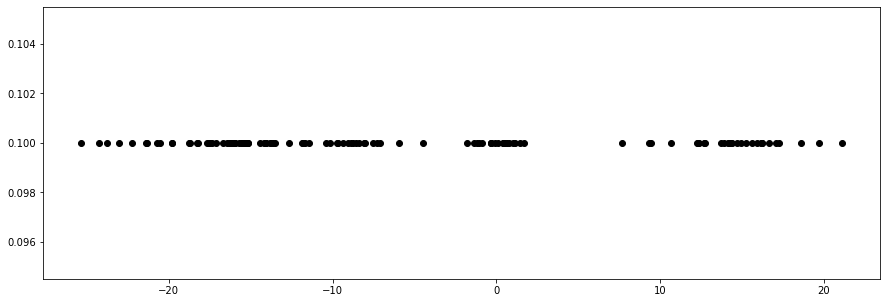

In [5]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,5))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')

It's not trivial to understand how many clusters are present. Such an issue is present also in the case of Expectation-Maximization (EM) on Gaussian Mixture Models (GMM) (the one we are going to implement) and K-means: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any data.

Usually, in order to achieve satisfactory clustering, one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters.

In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a moment to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are choosen without any specific criteria: we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

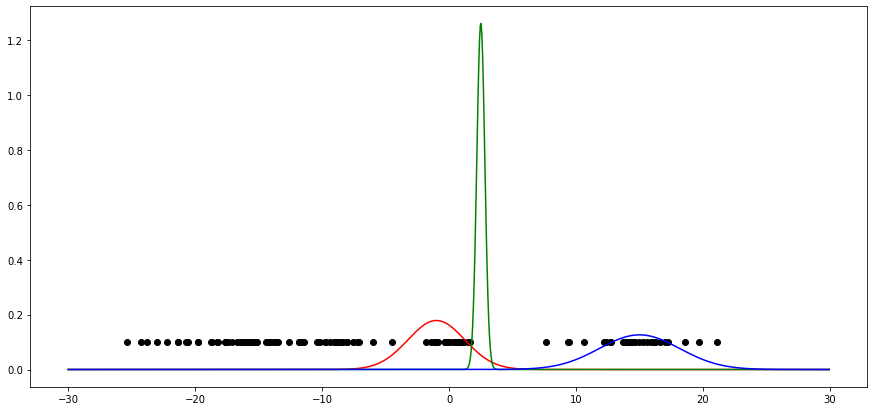

In [6]:
means = np.array([[-1],[2.5],[15]])      # shape (K,d)
covs  = np.array([[[5]],[[0.1]],[[10]]]) # shape (K,d,d) 
pi    = np.array([1/2, 1/4, 1/4])        # shape (K,)

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [7]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm under a GMM. Refer 
# to the slides you can find on moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the helper functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_pi = (1/len(W)) * np.sum(W, axis=0)
    # raise NotImplementedError() # Remove this line
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_means = np.zeros((W.shape[1], data.shape[1]))
    n = np.zeros((W.shape[1], data.shape[1]))
    
    for j in range(data.shape[1]):
        for i in range(W.shape[1]):
            n[i,j] = np.sum(data[:,j]*W[:,i])
            
    d = np.sum(W, axis=0).reshape(-1,1)
    
    new_means = n / d  
    # raise NotImplementedError() # Remove this line
    return new_means

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    m, n = data.shape
    k = W.shape[1]
    new_covs = np.zeros((k, n, n))
    
    for i in range(k):
        for j in range(m): 
            diff = np.reshape(data[j, :] - new_means[i, :], (n, 1))
            new_covs[i] += W[j, i] * np.multiply(diff, diff.T)      
        new_covs[i] /= np.sum(W[:, i])
    # raise NotImplementedError() # Remove this line
    return new_covs

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 


In [8]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)


In [9]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE
    W = np.zeros((len(data), len(pi)))
    
    n = np.zeros((len(data), len(pi)))

    for j in range(len(pi)):
        for i, x in enumerate(data):
            n[i,j] = gaussian_pdf(x, means[j], covs[j]) * pi[j]

    d = np.sum(n, axis=1)

    for i in range(len(pi)):
        W[:,i] = (n[:,i] / d)
        
    # raise NotImplementedError() # Remove this line
    return W


In [10]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [11]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE
    W = np.zeros((len(data), num_classes))
    classes = np.linspace(0, num_classes-1, num_classes, dtype=int)
    temp = []
    
    for i in range(num_classes):
        f = np.full(int(len(data)/num_classes), classes[i])
        temp = np.append(temp, f)
    
    temp = np.append(temp, np.full(int(len(data)%num_classes), classes[0]))
    
    np.random.shuffle(temp)

    for i in range(len(W)):
        W[i, temp.astype(int)[i]] = 1 
        
    # raise NotImplementedError() # Remove this line
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs


In [12]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

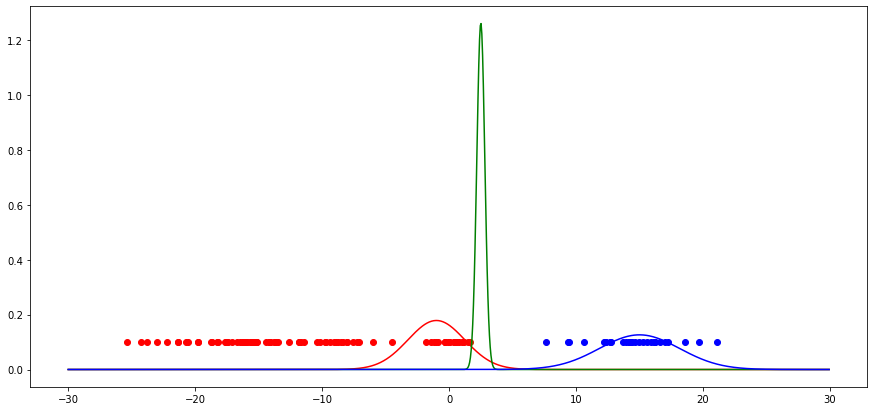

In [13]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall colour-code (rgb) each datum according to the class probabilities. Note that 
# it is not very likely to have a datum coming from the central (very peaked) distribution. 
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [14]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    '''
    # YOUR CODE HERE
    log_likelihood_list = []
    for x in data:
        likelihood = 0
        for j in range(len(pi)):
            likelihood += gaussian_pdf(x, means[j], covs[j]) * pi[j]
        log_likelihood_list.append(np.log(likelihood))
    log_likelihood = np.sum(log_likelihood_list)
    
    # raise NotImplementedError() # Remove this line
    return log_likelihood


In [15]:
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

Iteration 0, log likelihood -473.1436,  delta log likelihood 0.0706
Iteration 1, log likelihood -473.0623,  delta log likelihood 0.0813
Iteration 2, log likelihood -472.9546,  delta log likelihood 0.1077
Iteration 3, log likelihood -472.8061,  delta log likelihood 0.1485
Iteration 4, log likelihood -472.5914,  delta log likelihood 0.2147
Iteration 5, log likelihood -472.2592,  delta log likelihood 0.3323
Iteration 6, log likelihood -471.6960,  delta log likelihood 0.5632
Iteration 7, log likelihood -470.6399,  delta log likelihood 1.0560
Iteration 8, log likelihood -468.5584,  delta log likelihood 2.0815
Iteration 9, log likelihood -465.0114,  delta log likelihood 3.5470
Iteration 10, log likelihood -460.7948,  delta log likelihood 4.2166
Iteration 11, log likelihood -456.7212,  delta log likelihood 4.0737
Iteration 12, log likelihood -453.6610,  delta log likelihood 3.0602
Iteration 13, log likelihood -452.2165,  delta log likelihood 1.4445
Iteration 14, log likelihood -451.6274,  del

Text(0, 0.5, 'Log likelihood')

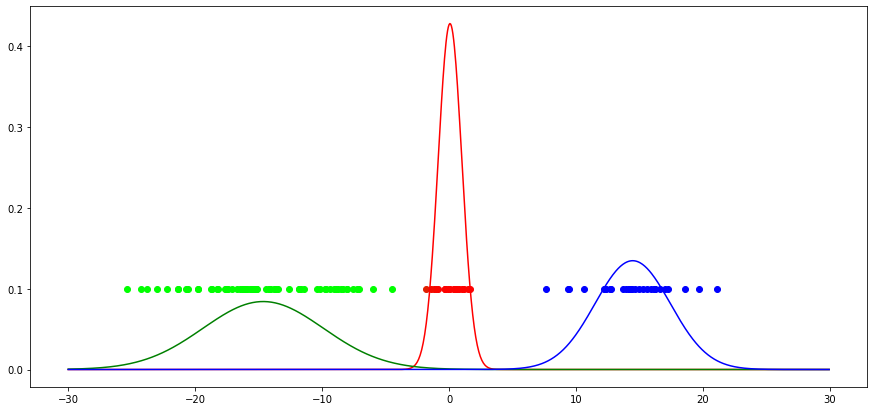

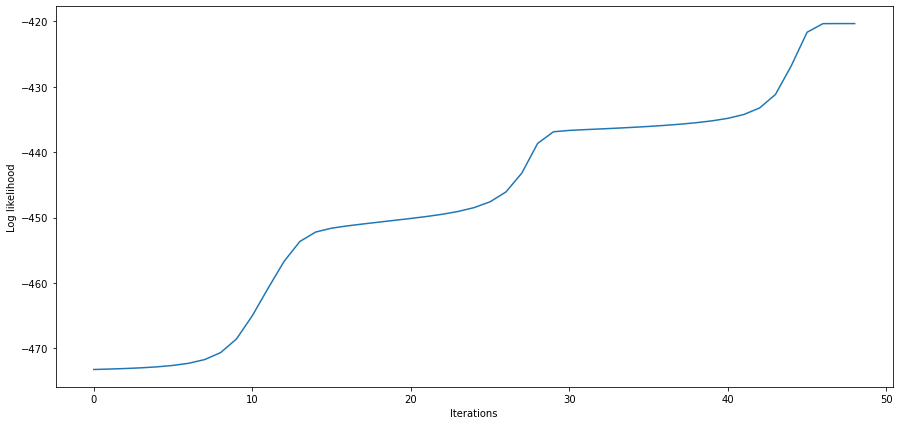

In [16]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exaggerate). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        W = E_step(data, pi, means, covs)
        pi, means, covs = M_step(data, W)
        # raise NotImplementedError() # Remove this line
        
        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')
            
        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or threshold on log likelihood improvement 
        # (use the break statement to stop while cycle)
        # YOUR CODE HERE
        if num_iter >= max_iter or (log_likelihood_train[-1] - log_likelihood_train[-2]) < epsilon:
            break
        # raise NotImplementedError() # Remove this line
        
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = 100  # to be overwritten
# YOUR CODE HERE
# raise NotImplementedError() # Remove this line
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [17]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -472.6968,  delta log likelihood 0.2151
Iteration 1, log likelihood -472.3912,  delta log likelihood 0.3056
Iteration 2, log likelihood -471.8582,  delta log likelihood 0.5330
Iteration 3, log likelihood -470.8155,  delta log likelihood 1.0427
Iteration 4, log likelihood -468.6795,  delta log likelihood 2.1360
Iteration 5, log likelihood -464.9849,  delta log likelihood 3.6946
Iteration 6, log likelihood -460.6571,  delta log likelihood 4.3279
Iteration 7, log likelihood -456.6103,  delta log likelihood 4.0468
Iteration 8, log likelihood -453.7717,  delta log likelihood 2.8386
Iteration 9, log likelihood -452.5332,  delta log likelihood 1.2385


We shall now try the same procedure with a 2-dimensional dataset.

Everything is the same as before but we can apprecaite a better visualization.

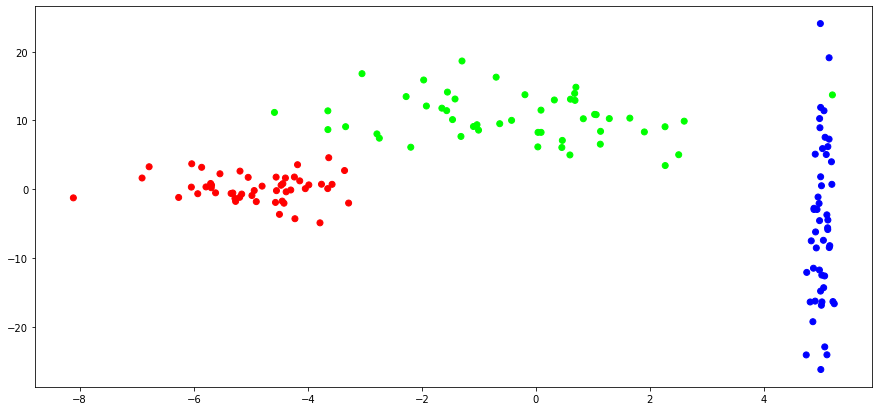

In [18]:
# Build the 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -972.7282,  delta log likelihood 1.3476
Iteration 1, log likelihood -969.4452,  delta log likelihood 3.2830
Iteration 2, log likelihood -961.1249,  delta log likelihood 8.3203
Iteration 3, log likelihood -946.7042,  delta log likelihood 14.4207
Iteration 4, log likelihood -930.7585,  delta log likelihood 15.9457
Iteration 5, log likelihood -916.0371,  delta log likelihood 14.7214
Iteration 6, log likelihood -902.5884,  delta log likelihood 13.4488
Iteration 7, log likelihood -891.8910,  delta log likelihood 10.6973
Iteration 8, log likelihood -881.6795,  delta log likelihood 10.2116
Iteration 9, log likelihood -865.4076,  delta log likelihood 16.2719
Iteration 10, log likelihood -829.8728,  delta log likelihood 35.5348
Iteration 11, log likelihood -768.1735,  delta log likelihood 61.6993
Iteration 12, log likelihood -760.3137,  delta log likelihood 7.8598
Iteration 13, log likelihood -755.0914,  delta log likelihood 5.2223
Iteration 14, log likelihood -751.2

<ipython-input-16-7f46a828c89c>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,7))


Iteration 20, log likelihood -731.9182,  delta log likelihood 1.3989
Iteration 21, log likelihood -731.0498,  delta log likelihood 0.8684
Iteration 22, log likelihood -729.7107,  delta log likelihood 1.3391
Iteration 23, log likelihood -726.8027,  delta log likelihood 2.9080
Iteration 24, log likelihood -721.7089,  delta log likelihood 5.0938
Iteration 25, log likelihood -719.2327,  delta log likelihood 2.4762
Iteration 26, log likelihood -719.1563,  delta log likelihood 0.0764
Iteration 27, log likelihood -719.1534,  delta log likelihood 0.0029
Iteration 28, log likelihood -719.1532,  delta log likelihood 0.0002


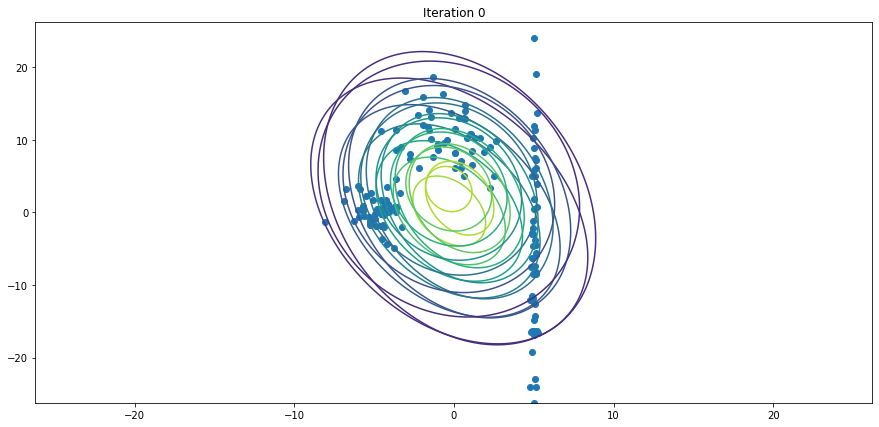

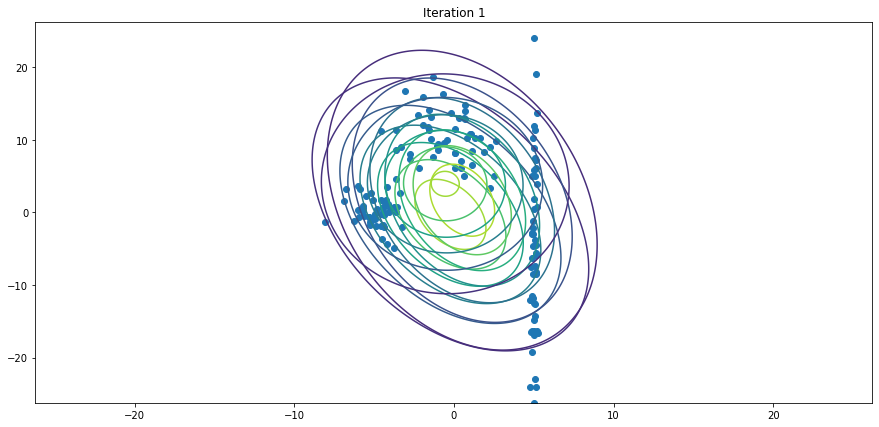

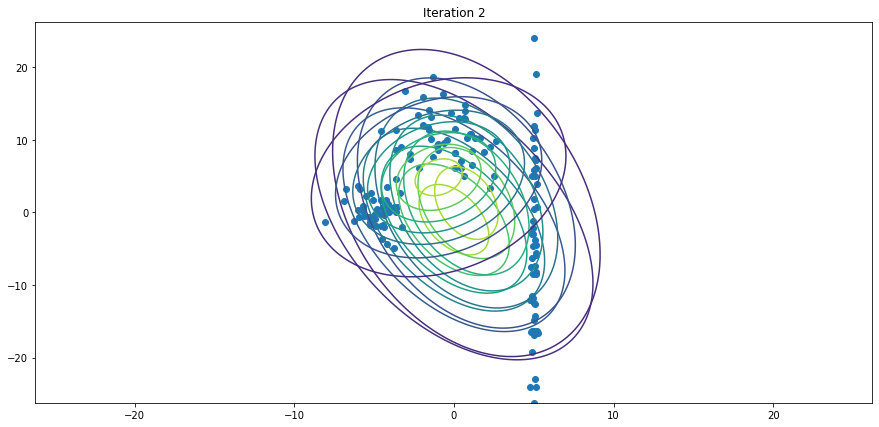

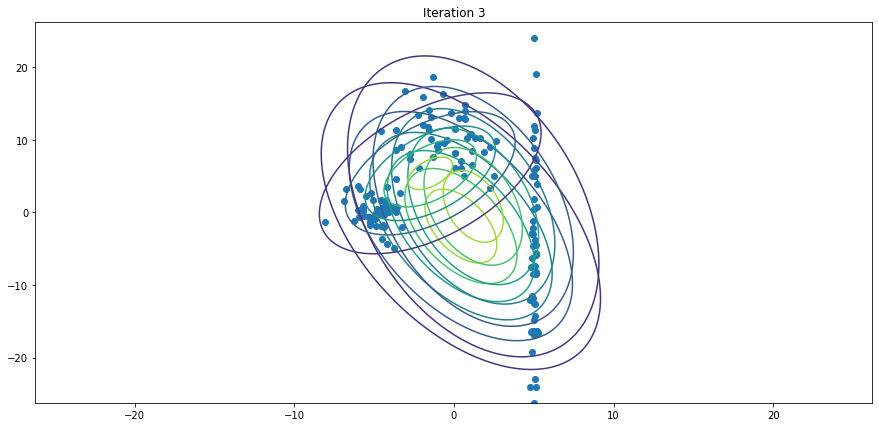

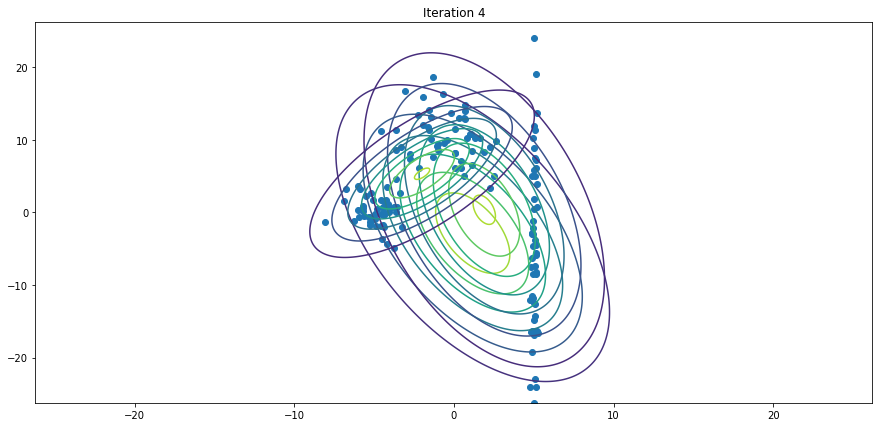

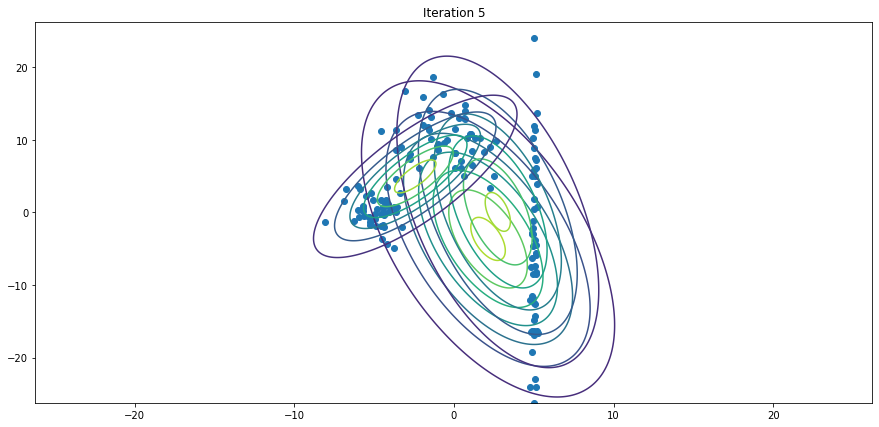

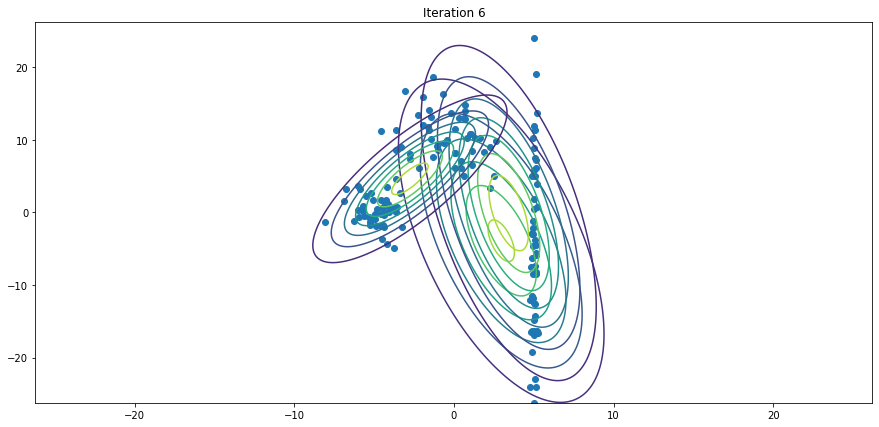

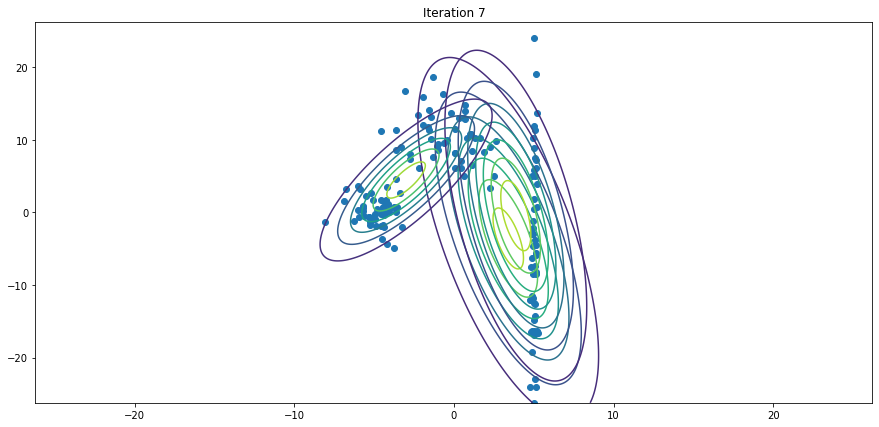

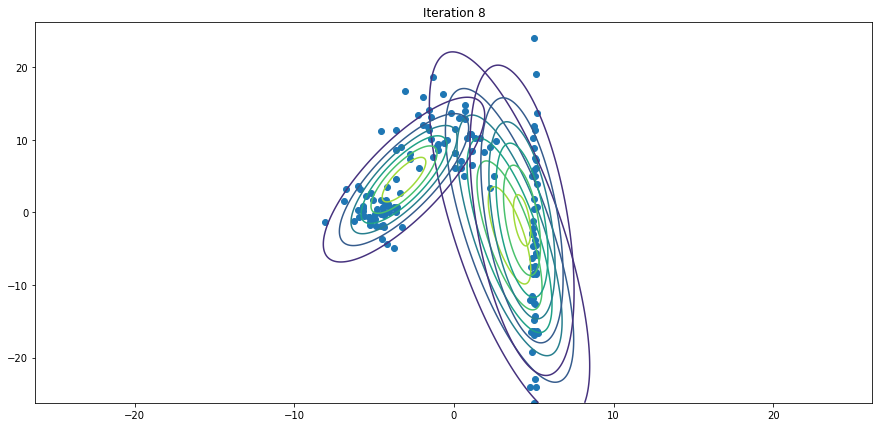

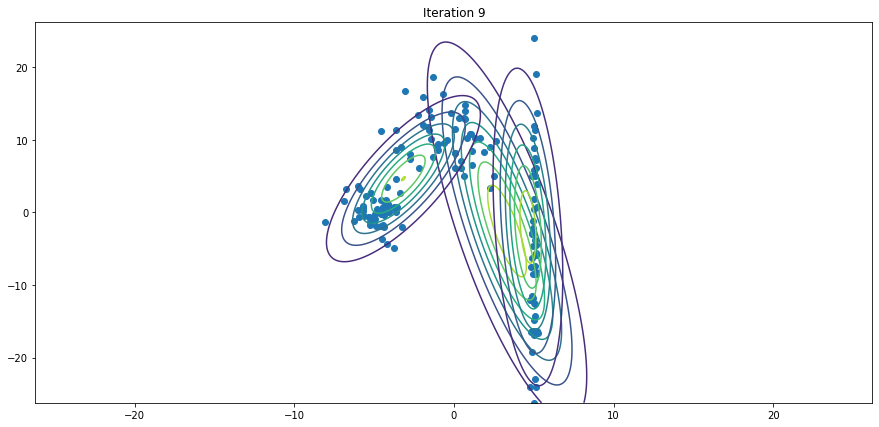

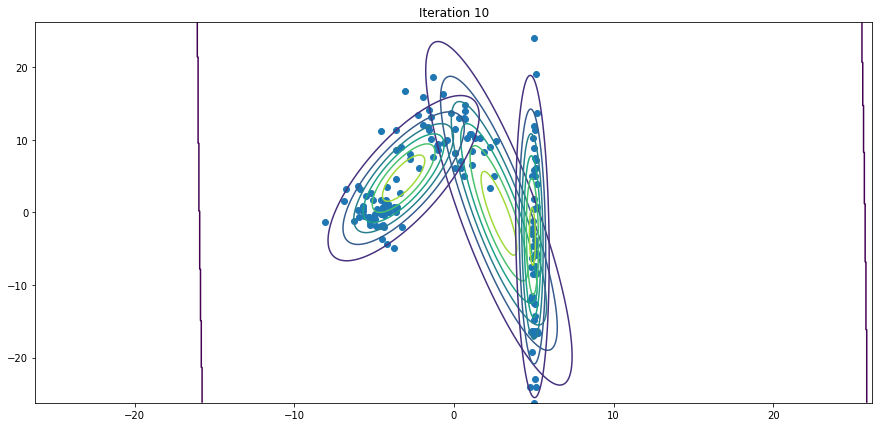

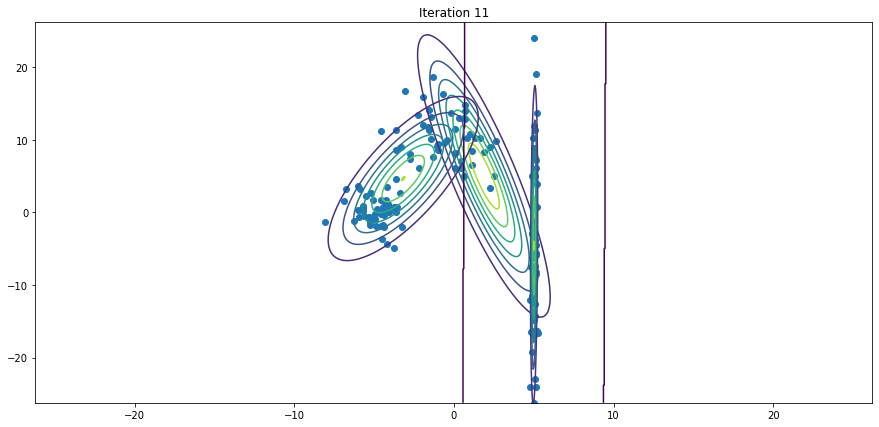

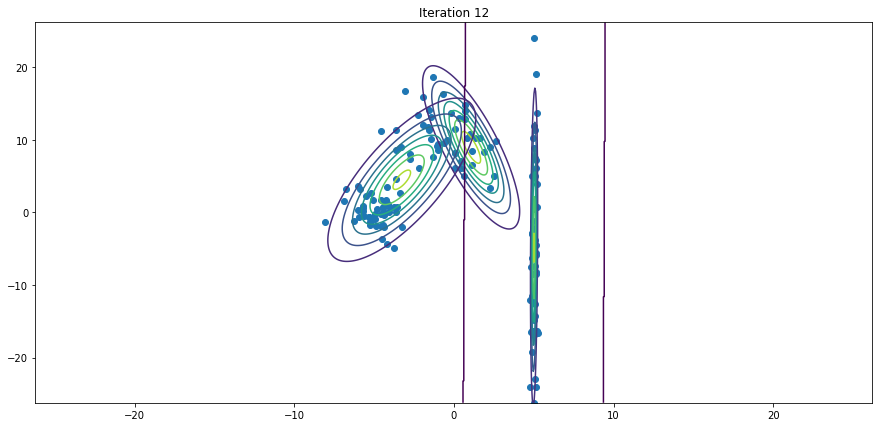

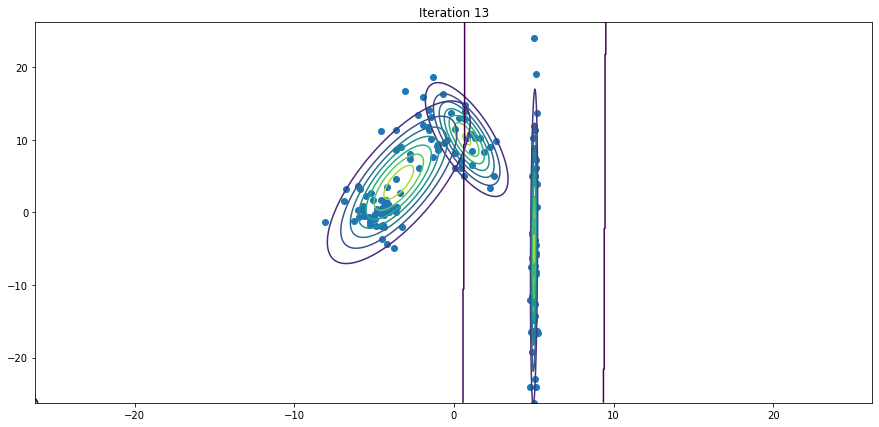

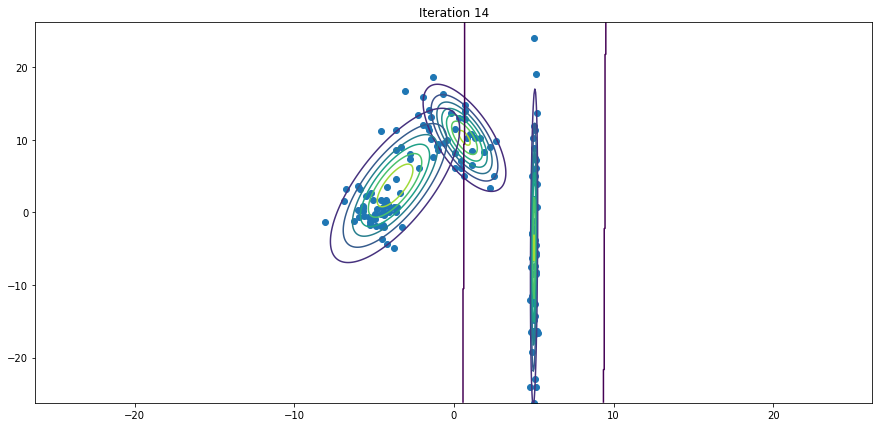

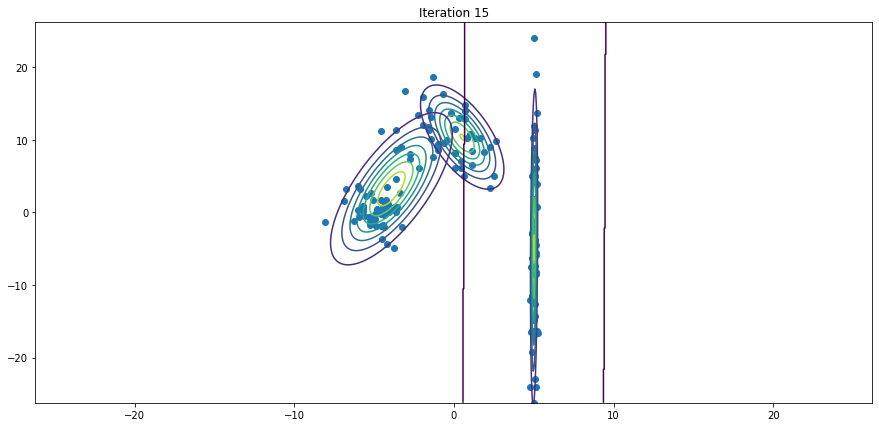

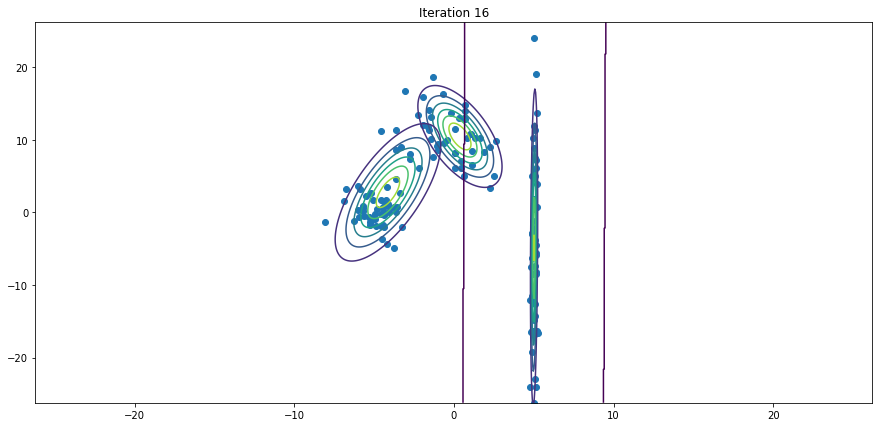

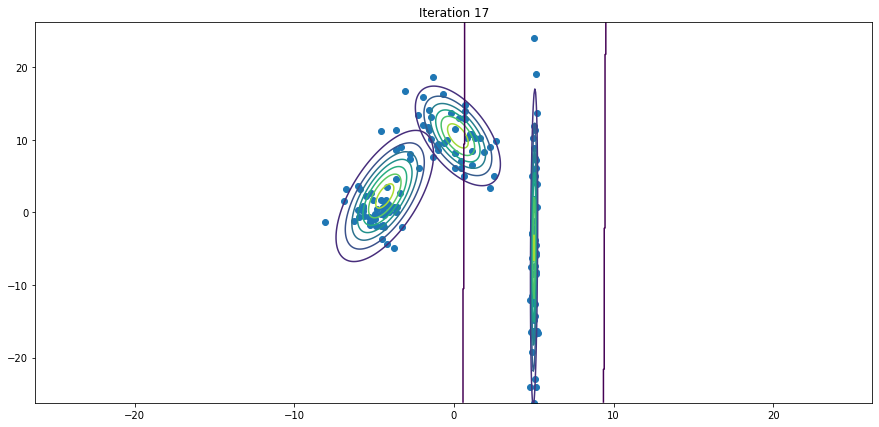

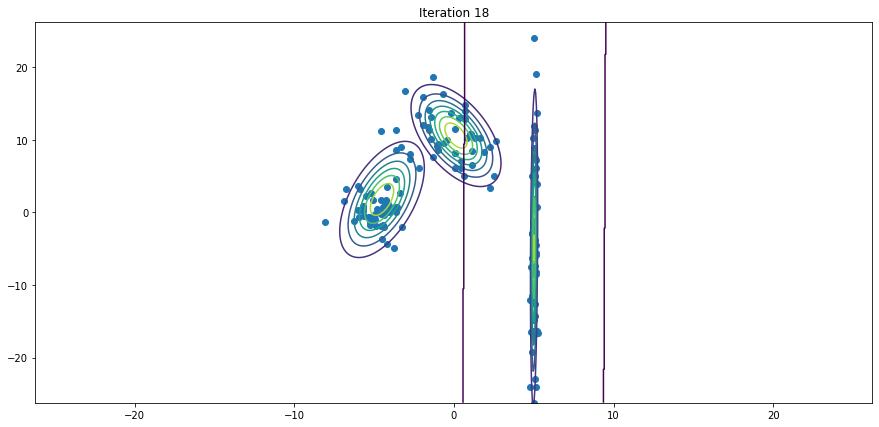

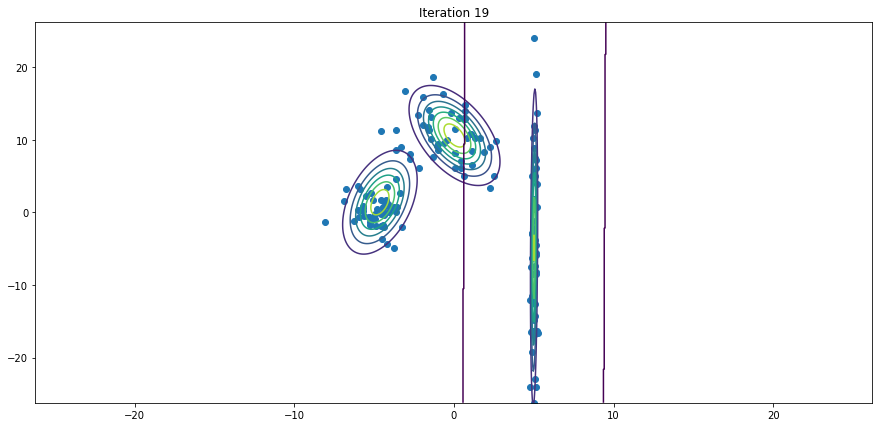

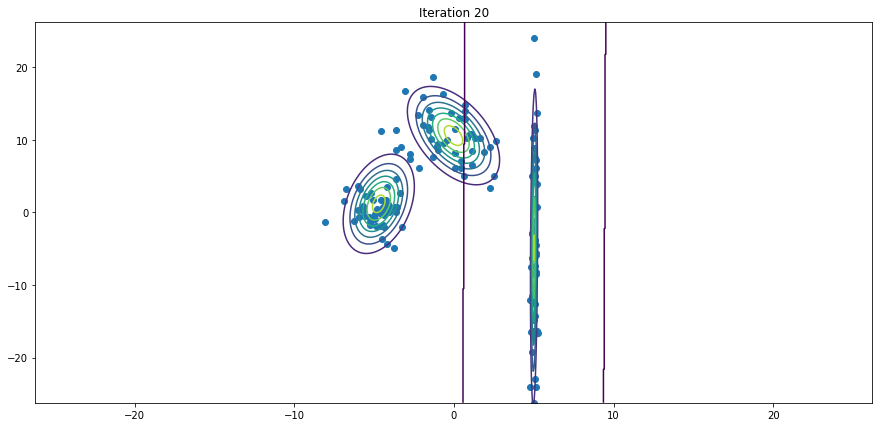

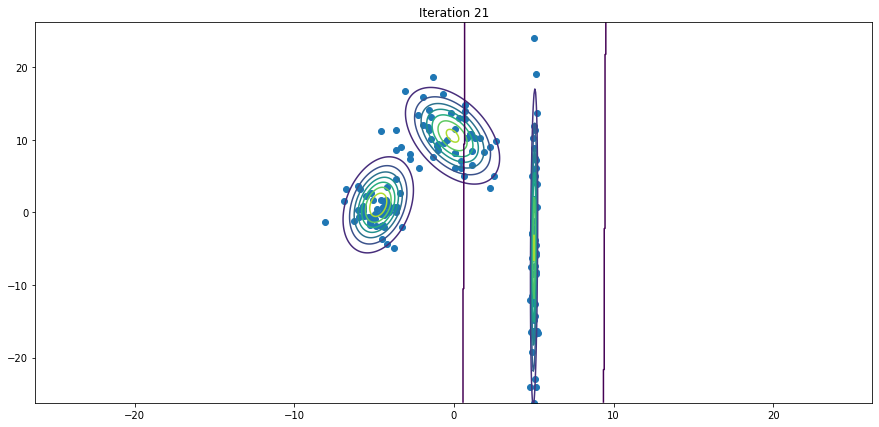

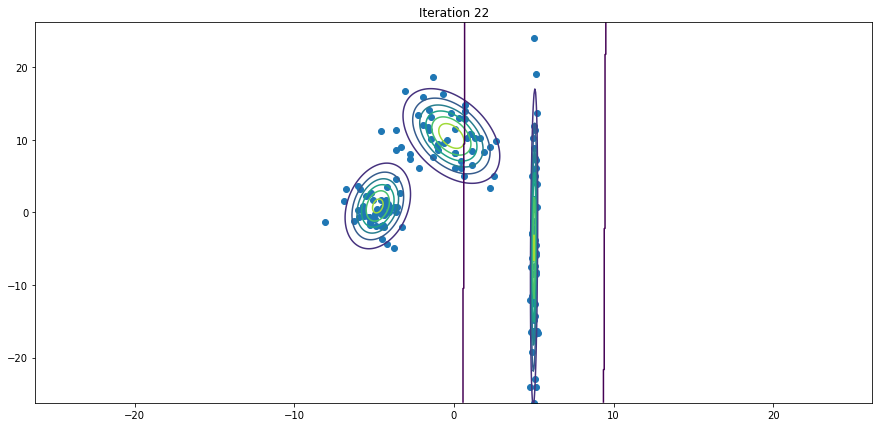

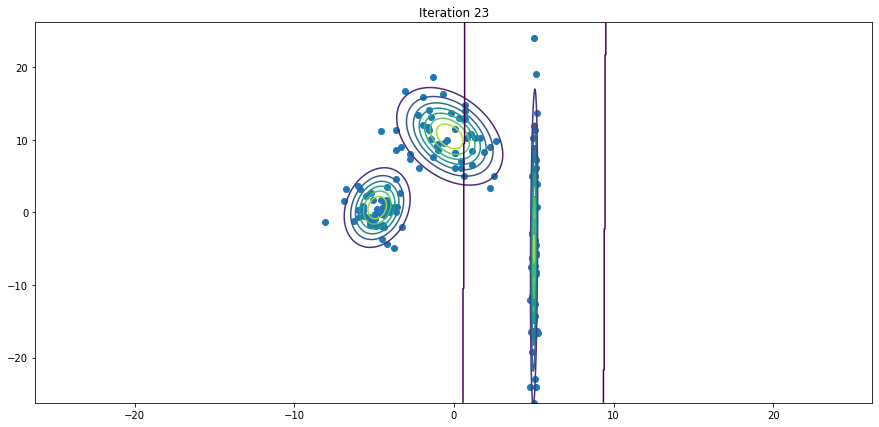

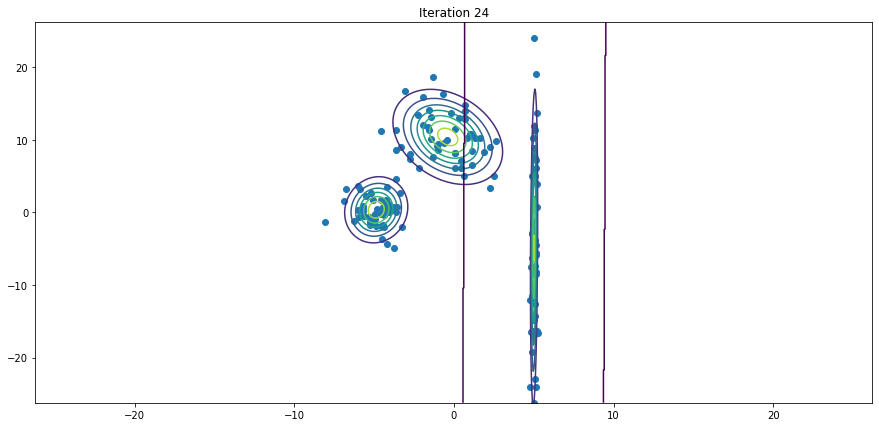

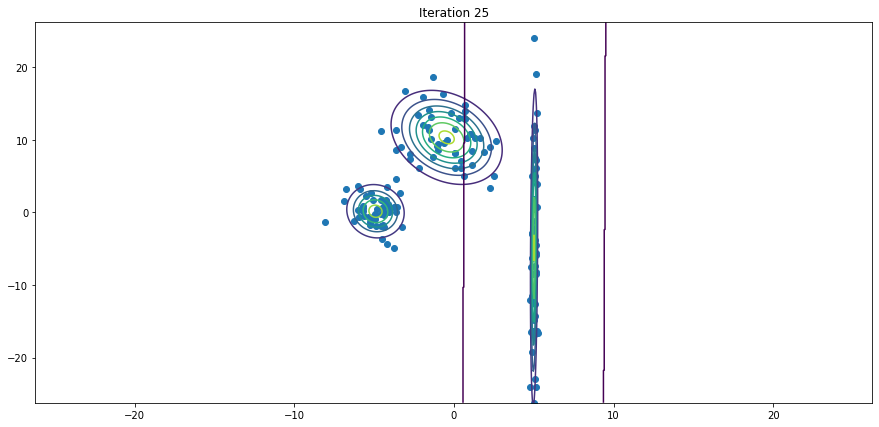

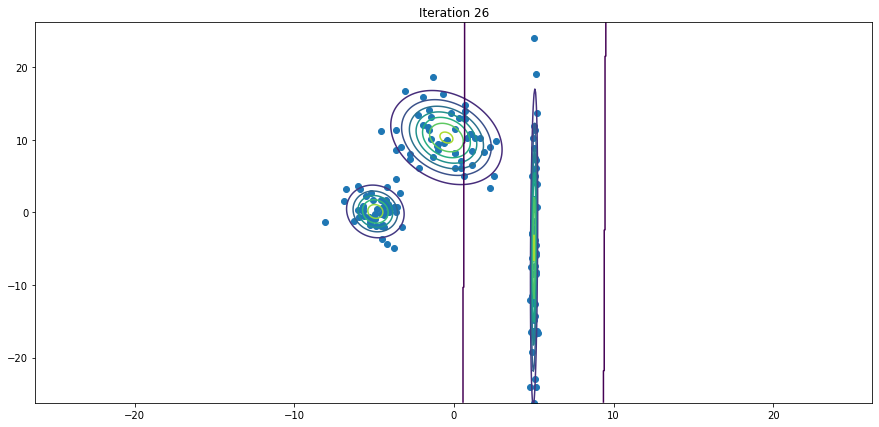

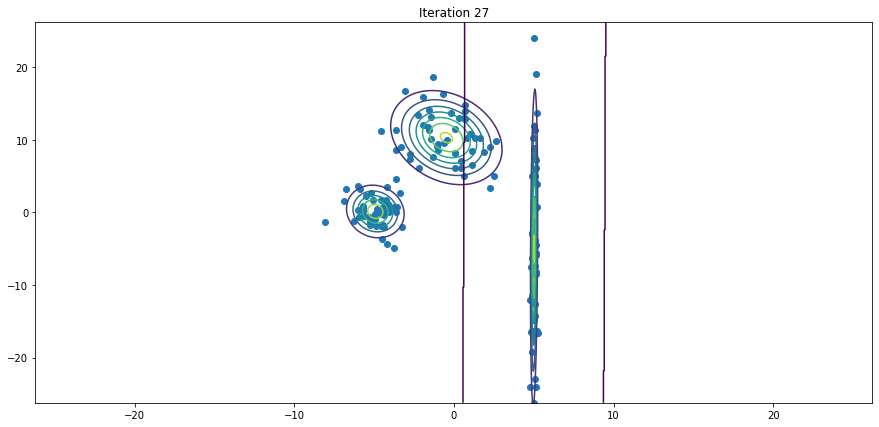

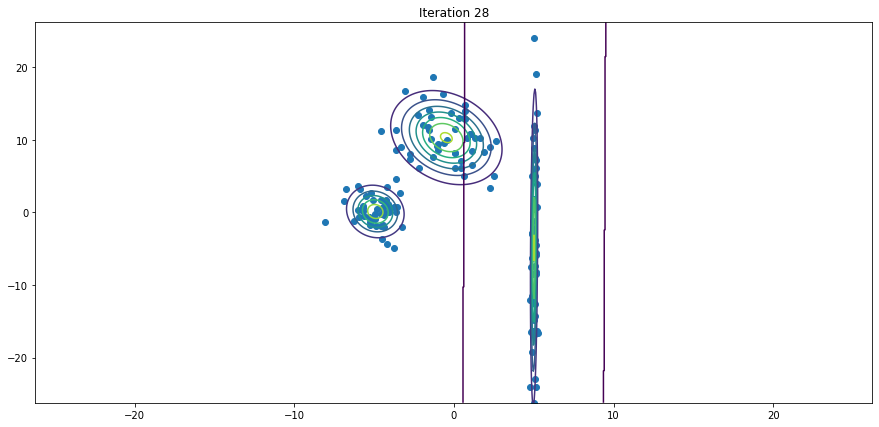

In [19]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

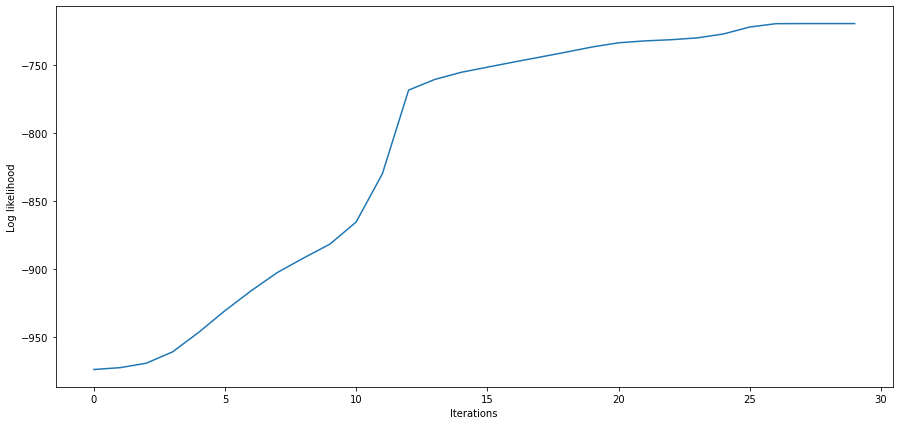

In [20]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

## TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in to do 4 with the ones in to do 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

In [21]:
# YOUR CODE HERE

# We can see that in the plot of TODO4 the 3 Gaussians doesn't fit correctly the data. This is because the chose randomly 
# the starting parameters of each model. On the other hand, in the plot of TODO6, the EM algorithm find a suboptimal set of 
# parameters, meaning that mean and covariance of each model are the ones are the parameters for which the data are most 
# likely to be generated. So we can claim that EM provided us a meaningful clustering.

# The log likelihood is monotonically increasing as we can expect from the theory. In fact we know that the likelihood at 
# iteration i+1 is > than the one at iteration i. So if we apply a log trasformation which is a monotonically increasing 
# function, we get again the same increasing behaviour. As we can see from the 2-d plots, from iteration 9, the algorithm 
# seems to have identified the optimal parameters, and in fact the subsequent plots are all very similar to the plot of the
# ninth iteration. We can also reach the same conclusion by observing the likelihood value as the number of iterations 
# increases. From about the ninth iteration, the likelihood value tends to increase much less than at the beginning. 

# Since the delta log likelihood is the improvement, it is not monotonically going to zero, but we can have some iterations
# with a higher improvement than the others.

# In our case, with the 2-D dataset, the termination criterion is on the threshold. In fact we have a maximum number of 
# iterations which is 150, and a threshold on log likelihood improvement of 0.001. As we can see we have an iteration in 
# which we have a  delta log likelihood is < 0.001 and so the algorithm stops.

In [22]:
# What is the effect of choosing a different number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -801.1914,  delta log likelihood 0.8217
Iteration 1, log likelihood -798.4329,  delta log likelihood 2.7585
Iteration 2, log likelihood -792.4378,  delta log likelihood 5.9951
Iteration 3, log likelihood -785.0189,  delta log likelihood 7.4189
Iteration 4, log likelihood -777.1390,  delta log likelihood 7.8800
Iteration 5, log likelihood -767.9260,  delta log likelihood 9.2129
Iteration 6, log likelihood -756.2338,  delta log likelihood 11.6922
Iteration 7, log likelihood -742.2182,  delta log likelihood 14.0156
Iteration 8, log likelihood -732.1312,  delta log likelihood 10.0870
Iteration 9, log likelihood -725.3312,  delta log likelihood 6.8000
Iteration 10, log likelihood -712.5853,  delta log likelihood 12.7459
Iteration 11, log likelihood -693.7846,  delta log likelihood 18.8007
Iteration 12, log likelihood -679.4039,  delta log likelihood 14.3807
Iteration 13, log likelihood -675.1792,  delta log likelihood 4.2246
Iteration 14, log likelihood -674.3136

Iteration 63, log likelihood -658.2241,  delta log likelihood 0.0849
Iteration 64, log likelihood -658.1420,  delta log likelihood 0.0821
Iteration 65, log likelihood -658.0653,  delta log likelihood 0.0767
Iteration 66, log likelihood -657.9958,  delta log likelihood 0.0695
Iteration 67, log likelihood -657.9342,  delta log likelihood 0.0616
Iteration 68, log likelihood -657.8804,  delta log likelihood 0.0538
Iteration 69, log likelihood -657.8334,  delta log likelihood 0.0470
Iteration 70, log likelihood -657.7922,  delta log likelihood 0.0413
Iteration 71, log likelihood -657.7554,  delta log likelihood 0.0368
Iteration 72, log likelihood -657.7222,  delta log likelihood 0.0332
Iteration 73, log likelihood -657.6918,  delta log likelihood 0.0304
Iteration 74, log likelihood -657.6636,  delta log likelihood 0.0281
Iteration 75, log likelihood -657.6374,  delta log likelihood 0.0262
Iteration 76, log likelihood -657.6128,  delta log likelihood 0.0246
Iteration 77, log likelihood -657.

Iteration 0, log likelihood -787.2583,  delta log likelihood 8.2224
Iteration 1, log likelihood -779.3855,  delta log likelihood 7.8728
Iteration 2, log likelihood -772.8172,  delta log likelihood 6.5683
Iteration 3, log likelihood -767.3595,  delta log likelihood 5.4577
Iteration 4, log likelihood -760.9697,  delta log likelihood 6.3898
Iteration 5, log likelihood -749.8448,  delta log likelihood 11.1249
Iteration 6, log likelihood -729.2771,  delta log likelihood 20.5677
Iteration 7, log likelihood -698.4723,  delta log likelihood 30.8047
Iteration 8, log likelihood -678.0135,  delta log likelihood 20.4589
Iteration 9, log likelihood -668.9754,  delta log likelihood 9.0381
Iteration 10, log likelihood -665.4075,  delta log likelihood 3.5679
Iteration 11, log likelihood -663.8882,  delta log likelihood 1.5193
Iteration 12, log likelihood -662.8698,  delta log likelihood 1.0184
Iteration 13, log likelihood -661.9940,  delta log likelihood 0.8758
Iteration 14, log likelihood -661.2079, 

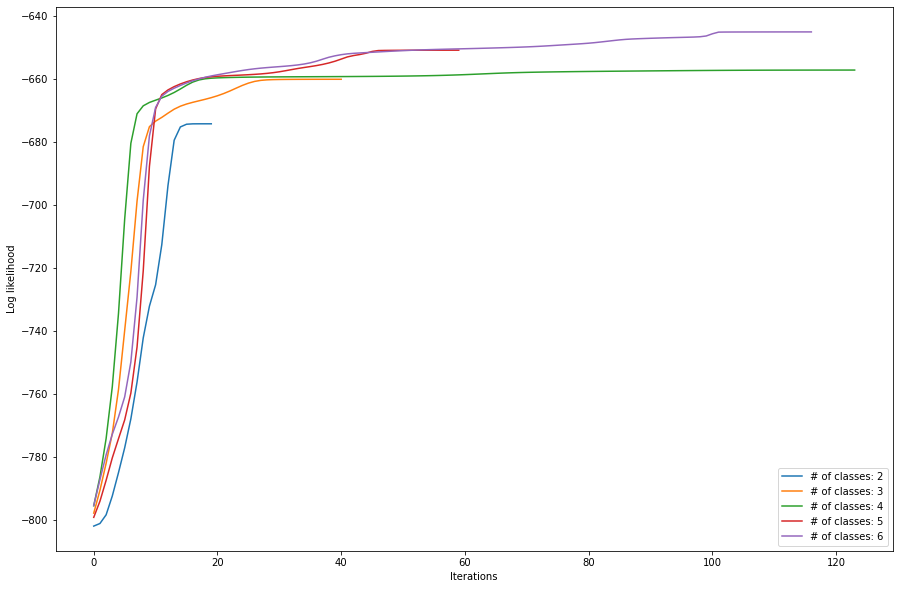

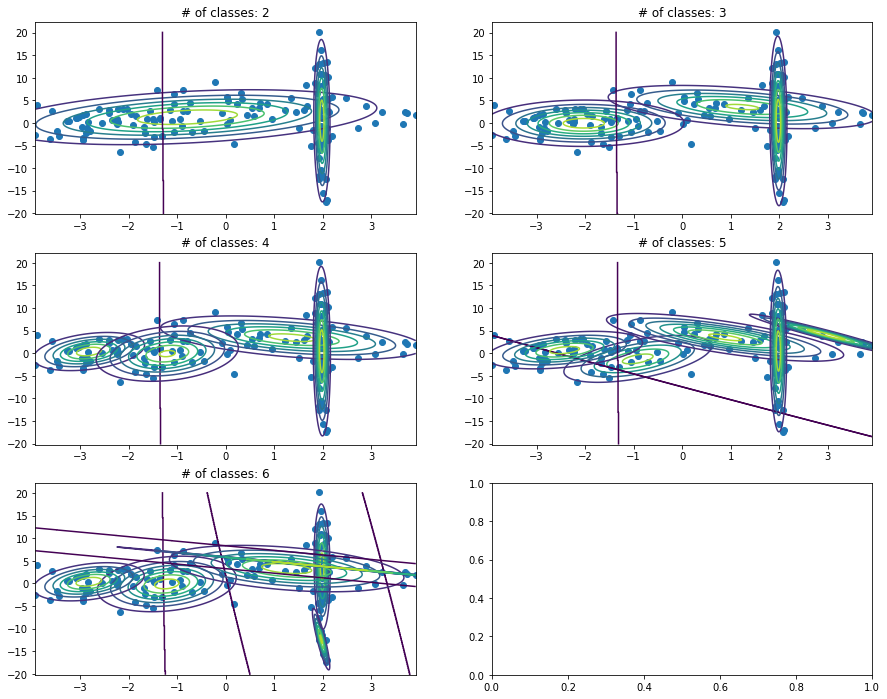

In [23]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,12))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST (which we already encountered in the last homework).

In the following we shall use the sklearn implementation of the EM.

Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we would expect to have each center representing one single digit).

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
import sklearn

skver = sklearn.__version__.split('.')
if int(skver[1]) >= 24:
    X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
else:
    X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

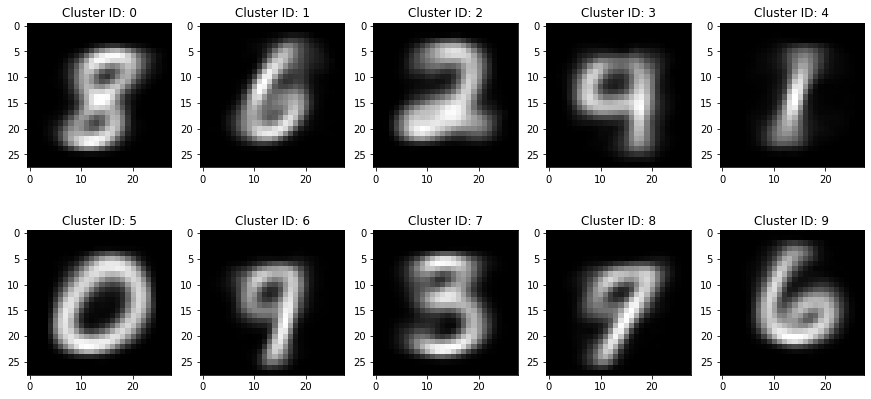

In [25]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object use set random_state=ID_number
gmm = GaussianMixture(n_components=K, random_state=ID_number).fit(x_train)
gmm_pred = gmm.predict(x_train)
# YOUR CODE HERE
# raise NotImplementedError() # Remove this line

plt, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [26]:
assert gmm_pred.shape == (m_t,)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [27]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predicitons) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    pred_labels = np.zeros_like(targets)
            
    for k in range(num_clusters):
        # YOUR CODE HERE
        indices = [i for i, x in enumerate(predictions) if x == k] # return all indeces which have value k
        labels = targets[indices] # extract all true labels in the indices 
        stats_mode = mode(labels)[0] # extract the first item in the list/tuple returned by the function
        pred_labels[indices] = stats_mode # assign the mode to the new variable in the position of the indices
        # raise NotImplementedError() # Remove this line
    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))


In [28]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)

In [29]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans object use set random_state=ID_number
gmm, gmm_pred_train, gmm_pred_test = GaussianMixture(n_components=K, random_state=ID_number).fit(x_train), gmm.predict(x_train), gmm.predict(x_test)
# YOUR CODE HERE
# raise NotImplementedError() # Remove this line
gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')


from sklearn.cluster import KMeans
kmeans, kmeans_pred_train, kmeans_pred_test = KMeans(n_clusters=K, random_state=ID_number).fit(x_train), KMeans(n_clusters=K, random_state=ID_number).fit_predict(x_train), KMeans(n_clusters=K, random_state=ID_number).fit(x_train).predict(x_test)
# YOUR CODE HERE
# raise NotImplementedError() # Remove this line
kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err    {training_error:.4f}, Test err {test_error:.4f}')

GMM Training err    0.3912, Test err 0.5689
Kmeans Training err 0.4088, Test err 0.4159
MLP Training err    0.0000, Test err 0.0589


In [30]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

## TODO 11 (max 10 lines)

- What is the effect of a wrong choice of the number of clusters? Briefly describe both log-likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- What does the 10 different plots in TODO 8 represent, with respect to the GMM approach?
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the plots in TODO 8? Why?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result?


(Answer in the next cell, no need to add code)

In [31]:
# YOUR CODE HERE

# We can see that, as we might expect, the log likelihood always increases, and in particular it increases rapidly in the 
# first iterations, while it tends to settle down at a certain point in the algorithm. We can also see that although the 
# number of classes is wrong the algorithm still tries to find the distributions that best represent our data. From the 2-d
# plot we see that the contour lines are Gaussians, as we should have expected, and that unlike kmeans method, the clusters
# can be streched, taking also the variance into account.

# They represent the corresponding label of the centers of the clusters found with respect to the GMM approach. Note that 
# in unsupervised learning we do not have labels, in fact the model trains without them, however in this case we have 
# labels (but still not using them to train the model) because of the dataset we are using.

# We could have predicted such a behavior of the errors from plots of TODO8. Indeed, in an ideal scenario we would expect 
# to have each center of the clusters representing one single digit, but in our case we can see that there are multiple 
# plots of the same digit (for example 9 and 6). This means that we have some data that should have been classified in the
# same cluster, but in our case are in different clusters. 

# Comparing GMM, Kmeans and NN, the best one is the NN model. We could have expected that, since this is a supervised 
# classification method, so the model will best fit the data in relation to the known targets. 